<a href="https://colab.research.google.com/github/dika-maulidal/ml/blob/main/Mobile%20Price%20Classification%20%5BRFClassifier%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMPORT COMMON PACKAGES DAN DATASET**

In [1]:
import pandas as pd
import missingno as msno

In [44]:
data = pd.read_csv('mobile.csv')

pd.options.display.max_columns = 100
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


## **CEK MISSING VALUES**

<Axes: >

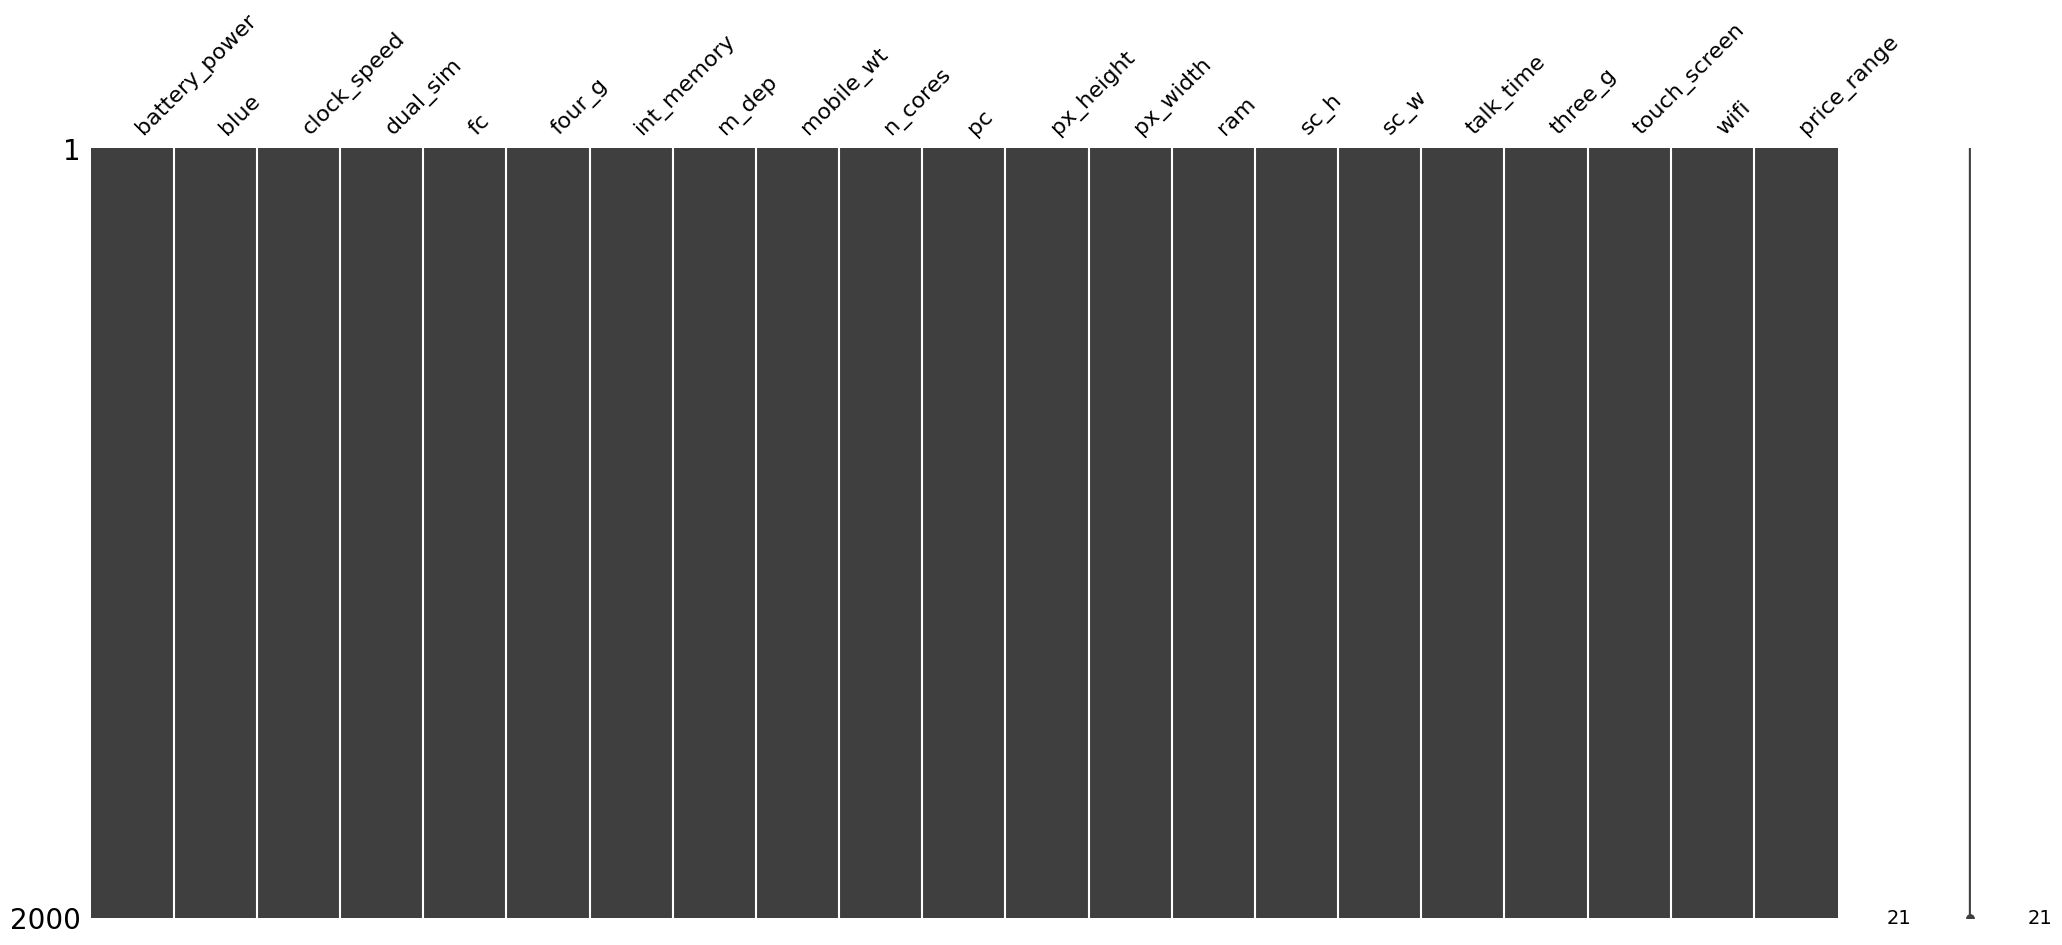

In [5]:
msno.matrix(data)

## **DATA SPLITTING**

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="price_range")
y = data["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 20), (400, 20), (1600,), (400,))

## **TRAINING MODEL: GridSearchCV & Hyperparameter Tuning + Full Features**

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
X_train.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
        ]), ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'])
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', RandomForestClassifier(random_state=42))
])

parameter = {
    'algo__n_estimators': [50, 100, 200],
    'algo__max_depth': [10, 20, None],
    'algo__max_features': ['sqrt', 'log2', None],
    'algo__min_samples_leaf': [1, 2, 4]
}

In [14]:
model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['battery_power',
                                                                          'clock_speed',
                                                                          'fc',
                                                                          'int_memory',
                                                                          'm_dep',
                                                                          'mobile_wt',
                                                                          'n_cores',
                                                                          'pc',
                                                                          'px_height',
                                                                          'px_width',
                                                                          'ram',
                                                                          'sc_h',
                                                                          'sc_w',
                                                                          'talk_time']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer...uent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['blue',
                                                                          'dual_sim',
                                                                          'four_g',
                                                                          'three_g',
                                                                          'touch_screen',
                                                                          'wifi'])])),
                                       ('algo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'algo__max_depth': [10, 20, None],
                         'algo__max_features': ['sqrt', 'log2', None],
                         'algo__min_samples_leaf': [1, 2, 4],
                         'algo__n_estimators': [50, 100, 200]},
             verbose=1)

In [15]:
print(f"Best parameters: {model.best_params_}")
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Best parameters: {'algo__max_depth': 10, 'algo__max_features': None, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.998125 0.8787526380017474 0.905


## **FEATURE IMPORTANCE (*MENCARI FEATURE YANG PENTING UNTUK NEXT TRAINING*)**

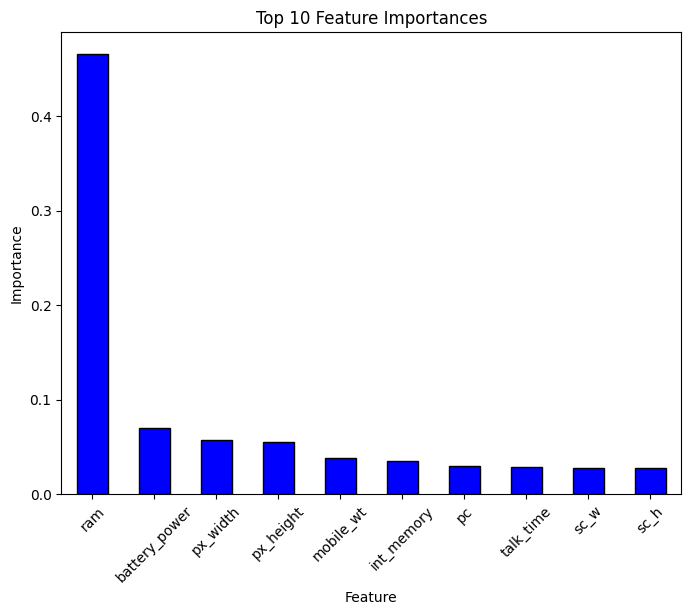

In [19]:
import matplotlib.pyplot as plt

pipeline.fit(X_train, y_train)
model = pipeline.named_steps['algo']
preprocessor = pipeline.named_steps['preprocessor']

num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'])

feature_names = list(num_features) + list(cat_features)
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(8, 6))
top_10_features.plot(kind='bar', color='blue', edgecolor='black')
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

## **Feature Selection & Polynomial + GridSearchCV**

In [23]:
from sklearn.preprocessing import PolynomialFeatures

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Mengimputasi nilai yang hilang
            ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Menambahkan PolynomialFeatures dengan degree=2
        ]), ['battery_power', 'px_height', 'px_width', 'ram', 'int_memory', 'mobile_wt']),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', RandomForestClassifier(random_state=42))
])

parameter = {
    'algo__n_estimators': [50, 100, 200],
    'algo__max_depth': [10, 20, None],
    'algo__max_features': ['sqrt', 'log2', None],
    'algo__min_samples_leaf': [1, 2, 4]
}

In [24]:
model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['battery_power',
                                                                          'px_height',
                                                                          'px_width',
                                                                          'ram',
                                                                          'int_memory',
                                                                          'mobile_wt'])])),
                                       ('algo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'algo__max_depth': [10, 20, None],
                         'algo__max_features': ['sqrt', 'log2', None],
                         'algo__min_samples_leaf': [1, 2, 4],
                         'algo__n_estimators': [50, 100, 200]},
             verbose=1)

In [25]:
print(f"Best parameters: {model.best_params_}")
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Best parameters: {'algo__max_depth': 20, 'algo__max_features': 'log2', 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
1.0 0.9231272822667727 0.95


## **Feature Selection + Polynomial Features & RandomSearchCV**

In [33]:
from sklearn.model_selection import RandomizedSearchCV

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), ['battery_power', 'px_height', 'px_width', 'ram', 'int_memory', 'mobile_wt']),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', RandomForestClassifier(random_state=42))
])

parameter = {
    'algo__n_estimators': [50, 100, 200],
    'algo__max_depth': [10, 20, None],
    'algo__max_features': ['sqrt', 'log2', None],
    'algo__min_samples_leaf': [1, 2, 4],
    'preprocessor__num__poly__degree': [2, 3],
}

# parameter = {
#     # Parameter untuk RandomForestClassifier
#     'algo__n_estimators': randint(50, 200),  # Mencari jumlah estimator acak antara 50 dan 200
#     'algo__max_depth': [10, 20, None],  # Nilai max_depth
#     'algo__max_features': ['sqrt', 'log2', None],  # Pilihan max_features
#     'algo__min_samples_leaf': [1, 2, 4],  # Pilihan min_samples_leaf

#     # Parameter untuk PolynomialFeatures
#     'preprocessor__num__poly__degree': randint(1, 5),  # Derajat polinomial acak antara 1 dan 5
#     'preprocessor__num__poly__include_bias': [True, False],  # Pilihan apakah bias disertakan atau tidak
# }

model = RandomizedSearchCV(pipeline, param_distributions=parameter, n_iter=50, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(include_bias=False))]),
                                                                               ['battery_power',
                                                                                'px_height',
                                                                                'px_width',
                                                                                'ram',
                                                                                'int_memory',
                                                                                'mobile_wt'])])),
                                             ('algo',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__max_depth': [10, 20, None],
                                        'algo__max_features': ['sqrt', 'log2',
                                                               None],
                                        'algo__min_samples_leaf': [1, 2, 4],
                                        'algo__n_estimators': [50, 100, 200],
                                        'preprocessor__num__poly__degree': [2,
                                                                            3]},
                   verbose=1)

In [34]:
print(f"Best parameters: {model.best_params_}")
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Best parameters: {'preprocessor__num__poly__degree': 3, 'algo__n_estimators': 200, 'algo__min_samples_leaf': 1, 'algo__max_features': 'sqrt', 'algo__max_depth': 20}
1.0 0.9318780698610789 0.9575


## **PREDIKSI**

In [35]:
X_train.iloc[1]

,565
battery_power,1271.0
blue,1.0
clock_speed,0.5
dual_sim,0.0
fc,12.0
four_g,0.0
int_memory,32.0
m_dep,0.1
mobile_wt,113.0
n_cores,7.0


In [42]:
import numpy as np

new_data = pd.DataFrame({
    'battery_power': np.random.randint(1000, 2000, 100),
    'blue': np.random.choice([0, 1], 100),
    'clock_speed': np.random.uniform(0.5, 2.5, 100),
    'dual_sim': np.random.choice([0, 1], 100),
    'fc': np.random.randint(5, 20, 100),
    'four_g': np.random.choice([0, 1], 100),
    'int_memory': np.random.randint(16, 128, 100),
    'm_dep': np.random.uniform(0.1, 1.0, 100),
    'mobile_wt': np.random.randint(100, 200, 100),
    'n_cores': np.random.randint(4, 8, 100),
    'pc': np.random.randint(10, 50, 100),
    'px_height': np.random.randint(1000, 2000, 100),
    'px_width': np.random.randint(1000, 2000, 100),
    'ram': np.random.randint(256, 2048, 100),
    'sc_h': np.random.randint(10, 20, 100),
    'sc_w': np.random.randint(10, 20, 100),
    'talk_time': np.random.randint(10, 20, 100),
    'three_g': np.random.choice([0, 1], 100),
    'touch_screen': np.random.choice([0, 1], 100),
    'wifi': np.random.choice([0, 1], 100)
})

prediction = model.predict(new_data)

print(f"Prediksi Price Range data baru: {prediction[0]}")

Prediksi Price Range data baru: 1


## **SAVE MODEL**

In [46]:
import pickle

with open('mobileclassifier.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan")

Model berhasil disimpan
